In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from pts.dataset.repository.datasets import dataset_recipes

from t2t_sb import T2TSBEstimator

## Prepeare data set

In [3]:
dataset = get_dataset("solar_nips", regenerate=False)

In [4]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [5]:
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)

In [6]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

## Evaluator

In [7]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

## ` T2T-RNN`

In [8]:
estimator = T2TSBEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=128,
    num_layers=3,
    dropout_rate=0.1,
    lags_seq=[1, 24 * 7],
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    scaling="std",
    trainer_kwargs=dict(max_epochs=50, accelerator="gpu", devices="1"),
)

In [9]:
predictor = estimator.train(dataset_train, cache_data=True)

/mnt/scratch/kashif/time_match/t2t_sb/diffusion.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.betas = to_torch(betas).to(device)
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.s

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 600.54895 (best 600.54895), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_70/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 496.15585 (best 496.15585), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_70/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 355.93723 (best 355.93723), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_70/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 298.90512 (best 298.90512), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_70/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 281.85919 (best 281.85919), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_70/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss

In [10]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))


Running evaluation: 7it [00:00, 94.75it/s]

Running evaluation: 7it [00:00, 112.18it/s]

Running evaluation: 7it [00:00, 111.88it/s]

Running evaluation: 7it [00:00, 113.05it/s]

Running evaluation: 7it [00:00, 113.44it/s]

Running evaluation: 7it [00:00, 112.86it/s]

Running evaluation: 7it [00:00, 113.26it/s]

Running evaluation: 7it [00:00, 113.58it/s]

Running evaluation: 7it [00:00, 108.38it/s]

Running evaluation: 7it [00:00, 112.96it/s]

Running evaluation: 7it [00:00, 112.07it/s]

Running evaluation: 7it [00:00, 113.35it/s]

Running evaluation: 7it [00:00, 113.13it/s]

Running evaluation: 7it [00:00, 113.22it/s]

Running evaluation: 7it [00:00, 112.30it/s]

Running evaluation: 7it [00:00, 112.91it/s]

Running evaluation: 7it [00:00, 112.56it/s]

Running evaluation: 7it [00:00, 113.01it/s]

Running evaluation: 7it [00:00, 112.12it/s]

Running evaluation: 7it [00:00, 113.98it/s]

Running evaluation: 7it [00:00, 113.72it/s]

Running evaluation: 7it [00:00, 112.40it/s]

Running ev

### Metrics

In [11]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 239.13375121690297
ND: 240.45349435566723
NRMSE: 364.38466404267706
MSE: 125949940.95929463


In [15]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS-Sum: 0.48362846540385784
ND-Sum: 0.5225882150465829
NRMSE-Sum: 0.9255859440197299
MSE-Sum: 15252900.761904761


In [12]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

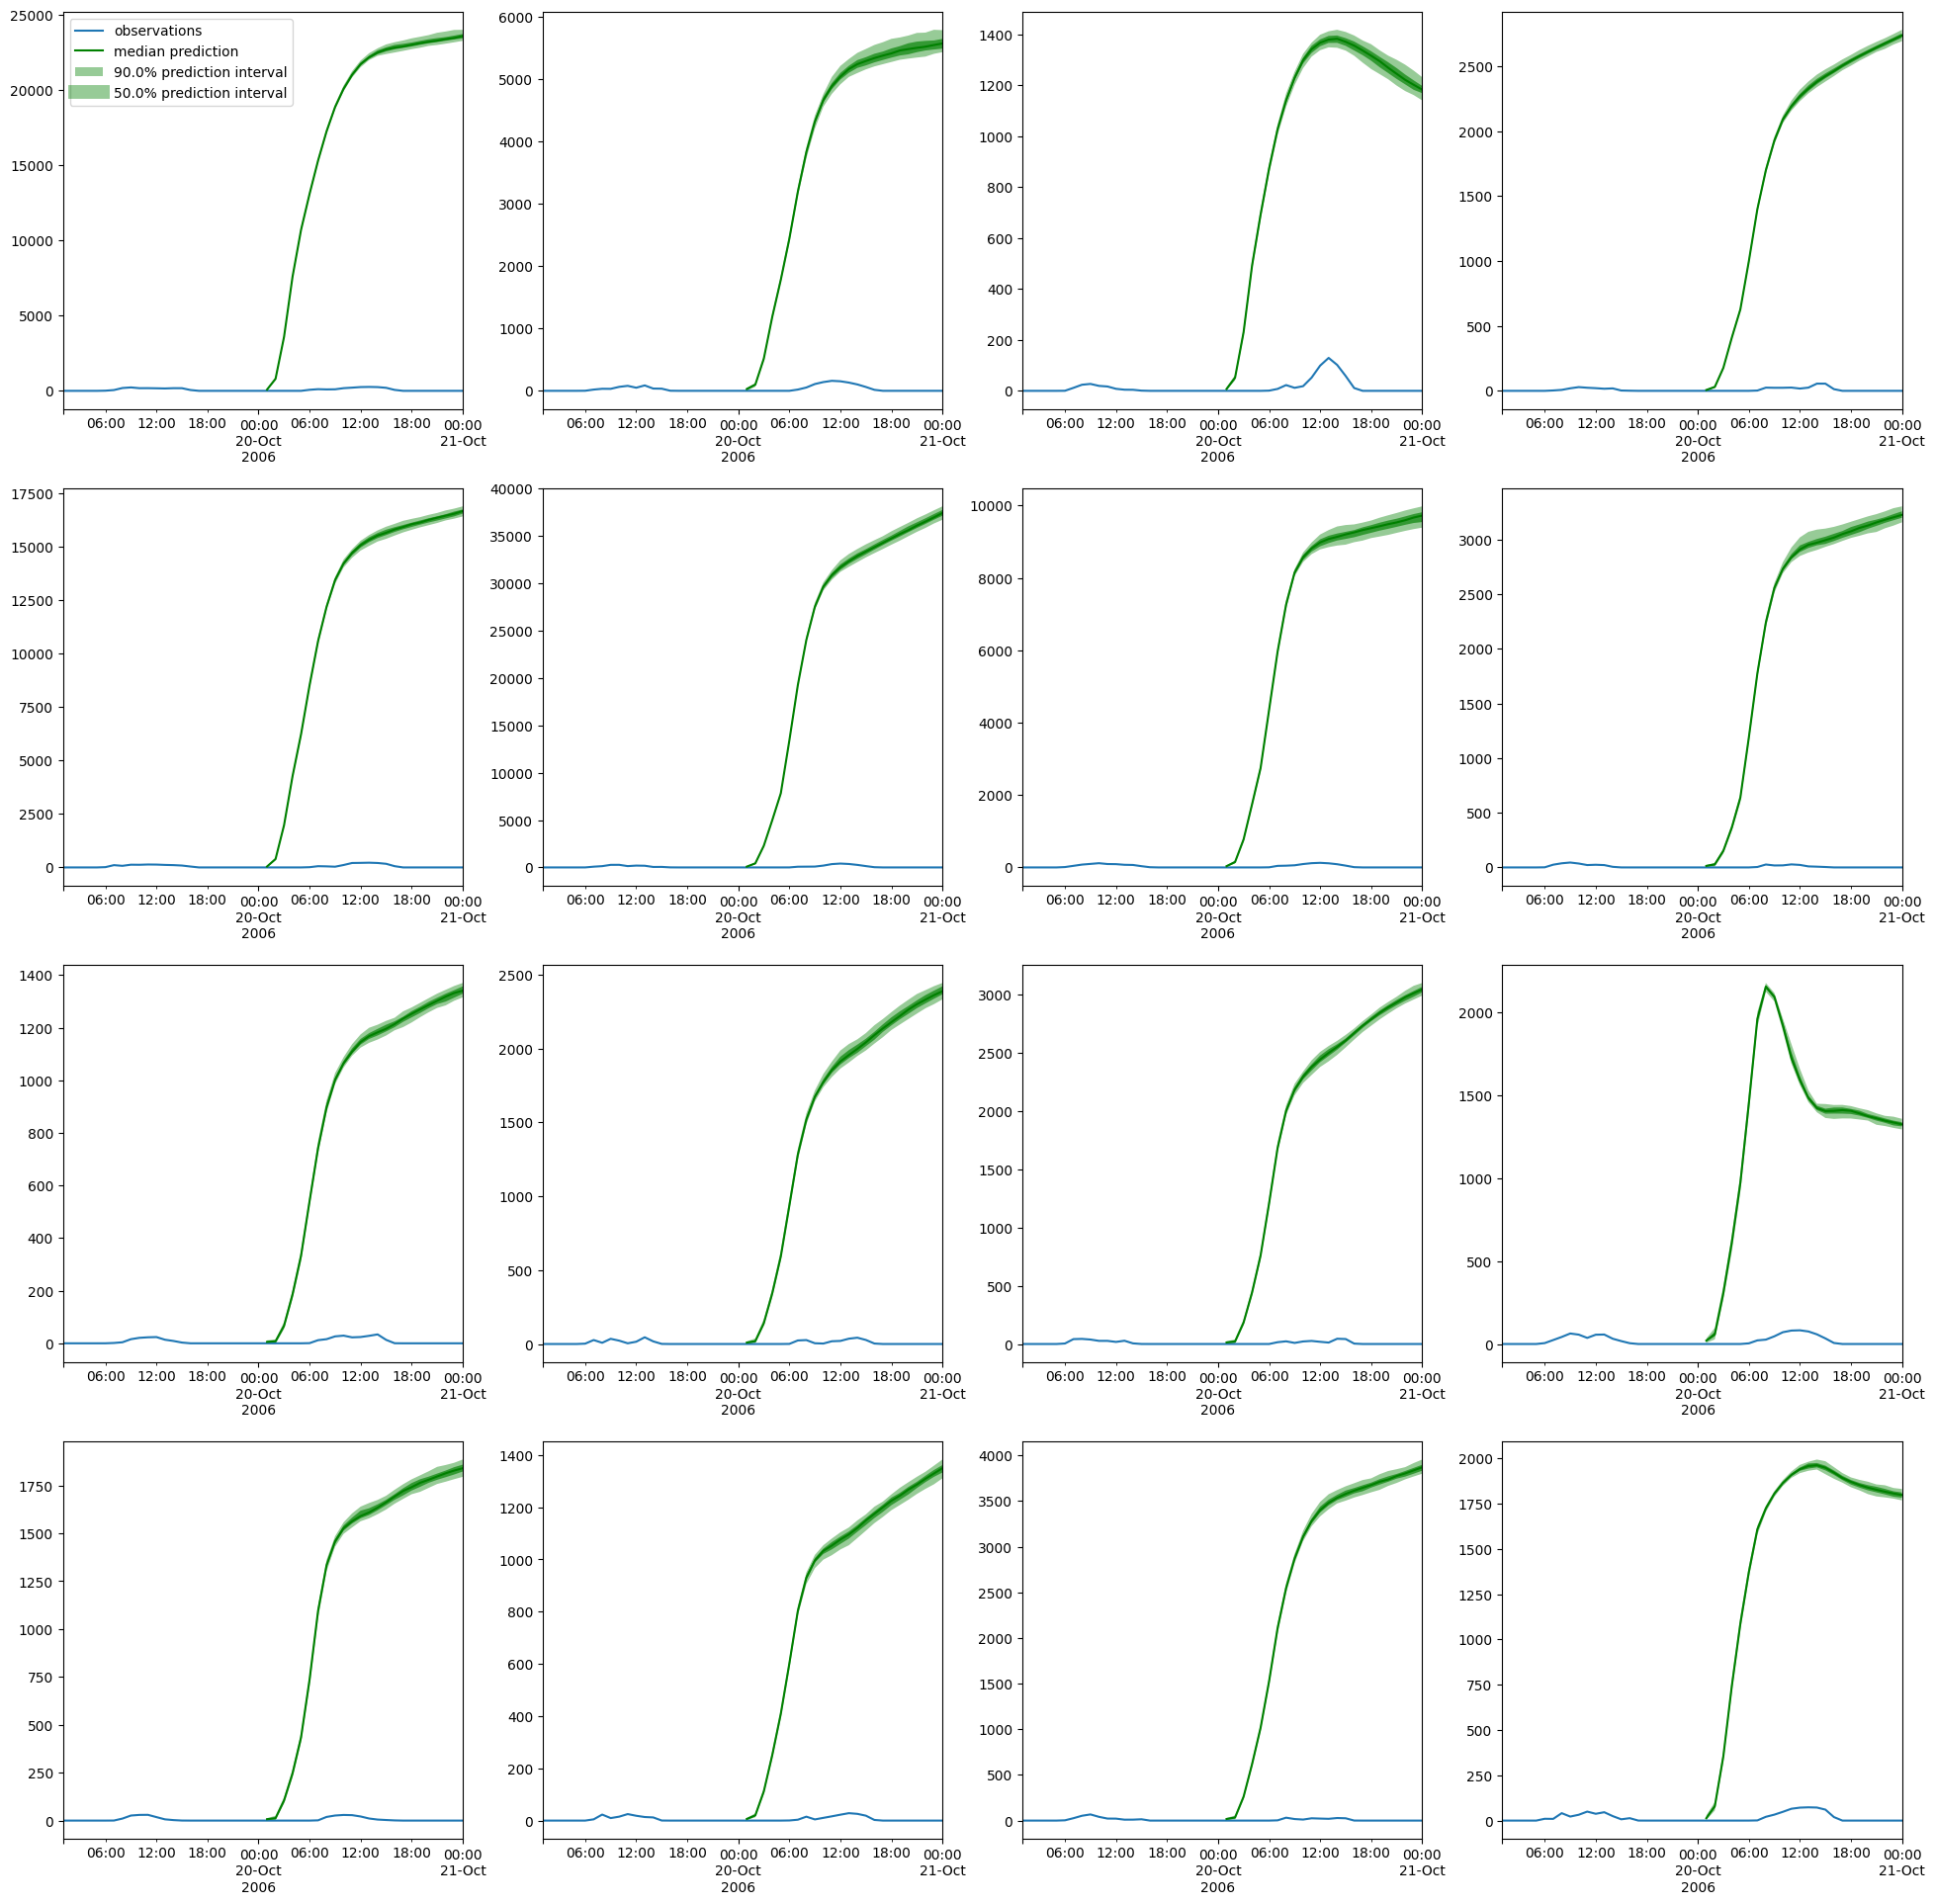

In [13]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()